In [1]:
import json
import os
import re
import unicodedata
from typing import List, Optional

print("Librerías importadas.")

Librerías importadas.


In [2]:
def normalizar(texto):
    if not isinstance(texto, str):
        return ""
    
    # minusculas
    texto = texto.lower()
    
    # quitar acentos
    texto_sin_acentos = ''.join(c for c in unicodedata.normalize('NFD', texto)
                                if unicodedata.category(c) != 'Mn')
    
    # quitar puntuación y espacios extra
    texto_limpio = re.sub(r'[^\w\s]', '', texto_sin_acentos)
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    
    return texto_limpio

print(f"Función 'normalizar' lista.")

Función 'normalizar' lista.


In [3]:
CARPETA_ENFERMEDADES= "CARPETA_ENFERMEDADES"
ARCHIVO_MALESTARES_LEVES = "enfermedades_db.json"

def cargar_datos_y_diccionario():

    data_enfermedades = []
    diccionario_sintomas = {}
    
    def procesar_enfermedad(enfermedad_obj):
        if not enfermedad_obj: return
        
        for sintoma in enfermedad_obj.get('sintomatologia', []):
            nombre_formal = sintoma.get('nombre')
            if not nombre_formal: continue
            
            clave_formal_norm = normalizar(nombre_formal)
            if clave_formal_norm:
                diccionario_sintomas[clave_formal_norm] = nombre_formal
            
            for variante in sintoma.get('otros_nombres', []):
                clave_variante_norm = normalizar(variante)
                if clave_variante_norm:
                    diccionario_sintomas[clave_variante_norm] = nombre_formal

    if os.path.exists(CARPETA_ENFERMEDADES):
        for nombre_archivo in os.listdir(CARPETA_ENFERMEDADES):
            if nombre_archivo.endswith('.json'):
                ruta_completa = os.path.join(CARPETA_ENFERMEDADES, nombre_archivo)
                try:
                    with open(ruta_completa, 'r', encoding='utf-8') as f:
                        enfermedad_grave = json.load(f)
                        data_enfermedades.append(enfermedad_grave)
                        procesar_enfermedad(enfermedad_grave)
                except Exception as e:
                    print(f"Error cargando {nombre_archivo}: {e}")
    else:
        print(f"Advertencia: No se encontró la carpeta '{CARPETA_ENFERMEDADES}'")

    if os.path.exists(ARCHIVO_MALESTARES_LEVES):
        try:
            with open(ARCHIVO_MALESTARES_LEVES, 'r', encoding='utf-8') as f:
                malestares_leves = json.load(f) 
                for malestar in malestares_leves:
                    data_enfermedades.append(malestar)
                    procesar_enfermedad(malestar)
        except Exception as e:
            print(f"Error cargando {ARCHIVO_MALESTARES_LEVES}: {e}")
    else:
        print(f"Advertencia: No se encontró el archivo '{ARCHIVO_MALESTARES_LEVES}'")

    print(f"Carga completa.")
    print(f"Se cargaron un total de {len(data_enfermedades)} perfiles de enfermedad.")
    print(f"El diccionario de síntomas tiene {len(diccionario_sintomas)} llaves normalizadas.")
    return data_enfermedades, diccionario_sintomas

data_db, diccionario_db = cargar_datos_y_diccionario()

Carga completa.
Se cargaron un total de 7 perfiles de enfermedad.
El diccionario de síntomas tiene 239 llaves normalizadas.


In [4]:
def encontrar_sintomas_en_texto(texto_usuario, diccionario_sintomas):
    texto_normalizado = normalizar(texto_usuario)
    sintomas_encontrados = set() 

    for llave_normalizada, valor_formal in diccionario_sintomas.items():
        llave_escapada = re.escape(llave_normalizada)
        patron_regex = r'\b' + llave_escapada + r'\b'
        
        if re.search(patron_regex, texto_normalizado):
            sintomas_encontrados.add(valor_formal)
    
    return list(sintomas_encontrados)

print("Función 'encontrar_sintomas_en_texto' lista.")

Función 'encontrar_sintomas_en_texto' lista.


In [5]:
def analizar_enfermedades(sintomas_detectados, data_enfermedades):

    if not sintomas_detectados:
        return []
    
    resultados = []
    sintomas_usuario_set = set(sintomas_detectados) 
    num_sintomas_usuario = len(sintomas_usuario_set)
    
    for enfermedad in data_enfermedades:
        sintomas_db_set = {s['nombre'] for s in enfermedad['sintomatologia']}
        sintomas_clave_set = set(enfermedad.get('sintomas_clave', []))
        
        coincidencias = sintomas_usuario_set & sintomas_db_set
        
        if not coincidencias:
            continue
        
        confianza_percent = (len(coincidencias) / num_sintomas_usuario) * 100
        
        if confianza_percent >= 100.0:
            confianza_percent = 90.0
        
        cobertura_enfermedad_percent = (len(coincidencias) / len(sintomas_db_set)) * 100
        coincidencias_clave = sintomas_usuario_set & sintomas_clave_set
        score_orden = (confianza_percent * 10) + (len(coincidencias_clave) * 5) + (cobertura_enfermedad_percent)
        
        resultados.append({
            'enfermedad': enfermedad['enfermedad'],
            'confianza': round(confianza_percent, 2),
            'score_interno': score_orden,
            'sintomas_coincidentes': list(coincidencias),
            'nivel_urgencia': enfermedad['nivel_urgencia'],
            'recomendacion_publica': enfermedad['recomendacion_publica']
        })
    
    return sorted(resultados, key=lambda x: x['score_interno'], reverse=True)

print("Función 'analizar_enfermedades' (con 99% cap) lista.")

Función 'analizar_enfermedades' (con 99% cap) lista.


In [6]:
def generar_respuesta_final(texto_usuario, umbral_confianza=30.0):
    """Orquesta todo el análisis. Esta es la función principal."""
    if not data_db:
         return {"error": True, "mensaje": "No se pudo cargar la base de datos de enfermedades."}

    sintomas_encontrados = encontrar_sintomas_en_texto(texto_usuario, diccionario_db)
    
    if not sintomas_encontrados:
        return {
            'diagnostico_probable': 'No se detectaron síntomas claros',
            'confianza': 0.0, 'nivel_urgencia': 'Bajo',
            'recomendacion_publica': 'No pudimos identificar síntomas. Intenta describir mejor cómo te sientes.',
            'sintomas_reportados': [texto_usuario], 'texto_original': texto_usuario
        }
        
    analisis = analizar_enfermedades(sintomas_encontrados, data_db)
    
    if not analisis:
        return {
            'diagnostico_probable': 'Síntomas generales detectados',
            'confianza': 0.0, 'nivel_urgencia': 'Bajo',
            'recomendacion_publica': 'Detectamos síntomas como ' + ', '.join(sintomas_encontrados) + ', pero no coinciden con un patrón claro. Vigila cómo te sientes.',
            'sintomas_reportados': sintomas_encontrados, 'texto_original': texto_usuario
        }

    mejor_match = analisis[0]
    
    if mejor_match['confianza'] < umbral_confianza or mejor_match['enfermedad'] == 'Malestares Generales':
        if mejor_match['enfermedad'] == 'Malestares Generales':
            return {
                'diagnostico_probable': 'Malestar General',
                'confianza': mejor_match['confianza'], 'nivel_urgencia': 'Bajo',
                'recomendacion_publica': mejor_match['recomendacion_publica'],
                'sintomas_reportados': sintomas_encontrados, 'texto_original': texto_usuario
            }
        return {
            'diagnostico_probable': 'Síntomas generales / No concluyente',
            'confianza': mejor_match['confianza'], 'nivel_urgencia': 'Bajo',
            'recomendacion_publica': 'Detectamos síntomas como ' + ', '.join(sintomas_encontrados) + ", pero la confianza es baja. Podría ser un malestar general. Vigila cómo te sientes.",
            'sintomas_reportados': sintomas_encontrados, 'texto_original': texto_usuario
        }

    return {
        'diagnostico_probable': f"Posible {mejor_match['enfermedad']}",
        'confianza': mejor_match['confianza'],
        'nivel_urgencia': mejor_match['nivel_urgencia'],
        'recomendacion_publica': mejor_match['recomendacion_publica'],
        'sintomas_reportados': sintomas_encontrados, 'texto_original': texto_usuario,
    }

print("Función 'generar_respuesta_final' ¡LISTA!")

Función 'generar_respuesta_final' ¡LISTA!


In [7]:
texto_grave = "me duele mucho la panza y me sangró la nariz"

resultado_grave = generar_respuesta_final(texto_grave)

print(f"--- RESULTADO DE LA MINERÍA (Prueba 2: Grave) ---")
print(f"Texto original: '{texto_grave}'\n")
print(json.dumps(resultado_grave, indent=2, ensure_ascii=False))

--- RESULTADO DE LA MINERÍA (Prueba 2: Grave) ---
Texto original: 'me duele mucho la panza y me sangró la nariz'

{
  "diagnostico_probable": "Posible Dengue Grave (Hemorrágico)",
  "confianza": 90.0,
  "nivel_urgencia": "Alto",
  "recomendacion_publica": "¡ATENCIÓN! Tus síntomas, especialmente el sangrado, dolor abdominal muy fuerte o vómitos persistentes, son señales de ALARMA. Esto podría ser Dengue Grave y es una EMERGENCIA MÉDICA. Dirígete al hospital o centro de salud más cercano INMEDIATAMENTE. No pierdas tiempo y no te automediques.",
  "sintomas_reportados": [
    "sangrado",
    "dolor abdominal intenso"
  ],
  "texto_original": "me duele mucho la panza y me sangró la nariz"
}


In [8]:
texto_de_prueba = "Hola, me siento mal. Tengo CALENTURA y mucho Dolor de Huesos. Tambien tengo los ójos rojos."

print(f"--- RESULTADO (Prueba Final) ---")
print(f"Texto original: '{texto_de_prueba}'\n")

resultado = generar_respuesta_final(texto_de_prueba)

print(json.dumps(resultado, indent=2, ensure_ascii=False))

--- RESULTADO (Prueba Final) ---
Texto original: 'Hola, me siento mal. Tengo CALENTURA y mucho Dolor de Huesos. Tambien tengo los ójos rojos.'

{
  "diagnostico_probable": "Posible Zika",
  "confianza": 66.67,
  "nivel_urgencia": "Medio",
  "recomendacion_publica": "Tus síntomas (especialmente la erupción, los ojos rojos y la fiebre leve) sugieren que podrías tener Zika. Es importante consultar a un médico para confirmar, especialmente si estás embarazada o planeas estarlo. Evita la picadura de mosquitos para no propagar la enfermedad y mantente bien hidratado.",
  "sintomas_reportados": [
    "fiebre leve",
    "dolor muscular y articular",
    "conjuntivitis"
  ],
  "texto_original": "Hola, me siento mal. Tengo CALENTURA y mucho Dolor de Huesos. Tambien tengo los ójos rojos."
}


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Creando Reportes Simulados ---")

reportes_con_ubicacion = [
    {"texto": "tengo calentura y dolor de cabeza", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "me duelen los huesos y tengo fiebre", "municipio": "San Cristóbal"},
    {"texto": "me salieron ronchitas y tengo los ojos rojos", "municipio": "Tapachula"},
    {"texto": "me duele mucho la panza y me sangró la nariz", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "tengo fiebre y me duelen las coyunturas", "municipio": "Chiapa de Corzo"},
    {"texto": "solo tengo tos y estornudos", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "me duele el cuerpo y la cabeza", "municipio": "San Cristóbal"},
    {"texto": "tengo calentura fuerte y dolor detras de los ojos", "municipio": "Tapachula"},
    {"texto": "me siento muy cansado y con calentura", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "me salio un salpullido y tengo ojos rojos", "municipio": "Tapachula"},
    {"texto": "vomité y me duele la panza horrible", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "tengo dolor de cuerpo y fiebre", "municipio": "San Cristóbal"},
    {"texto": "me sangraron las encías", "municipio": "Tuxtla Gutiérrez"}, 
    {"texto": "fiebre que sube y baja con escalofríos", "municipio": "Palenque"}, 
    {"texto": "dolor de huesos, fiebre y ronchas", "municipio": "Tapachula"},
    {"texto": "tos, estornudos y nariz tapada", "municipio": "Chiapa de Corzo"},
    {"texto": "me duelen los ojos y la cabeza", "municipio": "Tuxtla Gutiérrez"},
    {"texto": "tengo escalofrios y sudo mucho", "municipio": "Palenque"} 
]

print(f"Se simularán {len(reportes_con_ubicacion)} reportes de pacientes.")

--- Creando Reportes Simulados ---
Se simularán 18 reportes de pacientes.


In [10]:
datos_para_mapa = []

print("Procesando reportes simulados con la minería de texto...")

for reporte in reportes_con_ubicacion:
    sintomas = encontrar_sintomas_en_texto(reporte["texto"], diccionario_db)
    municipio = reporte["municipio"]
    
    for sintoma in sintomas:
        datos_para_mapa.append({"sintoma": sintoma, "municipio": municipio})

df_mapa = pd.DataFrame(datos_para_mapa)

print("\n--- Datos listos para el mapa de calor (primeras 5 filas) ---")
print(df_mapa.head())

Procesando reportes simulados con la minería de texto...

--- Datos listos para el mapa de calor (primeras 5 filas) ---
                      sintoma         municipio
0                 fiebre leve  Tuxtla Gutiérrez
1             dolor de cabeza  Tuxtla Gutiérrez
2                 fiebre leve     San Cristóbal
3  dolor muscular y articular     San Cristóbal
4            erupción cutánea         Tapachula


In [11]:
tabla_calor = pd.crosstab(df_mapa['sintoma'], df_mapa['municipio'])

print("--- Tabla de Datos del Mapa de Calor ---")
print("(Esta es la tabla que alimenta la gráfica y tu panel web)")
print(tabla_calor)

--- Tabla de Datos del Mapa de Calor ---
(Esta es la tabla que alimenta la gráfica y tu panel web)
municipio                   Chiapa de Corzo  Palenque  San Cristóbal  \
sintoma                                                                
congestión nasal                          1         0              0   
conjuntivitis                             0         0              0   
cuerpo cortado                            0         0              1   
dolor abdominal intenso                   0         0              0   
dolor de cabeza                           0         0              0   
dolor muscular y articular                1         0              2   
dolor retroocular                         0         0              0   
erupción cutánea                          0         0              0   
escalofríos                               0         2              0   
estornudos                                1         0              0   
fatiga extrema                       


--- Generando Visualizacion del Mapa de Calor ---


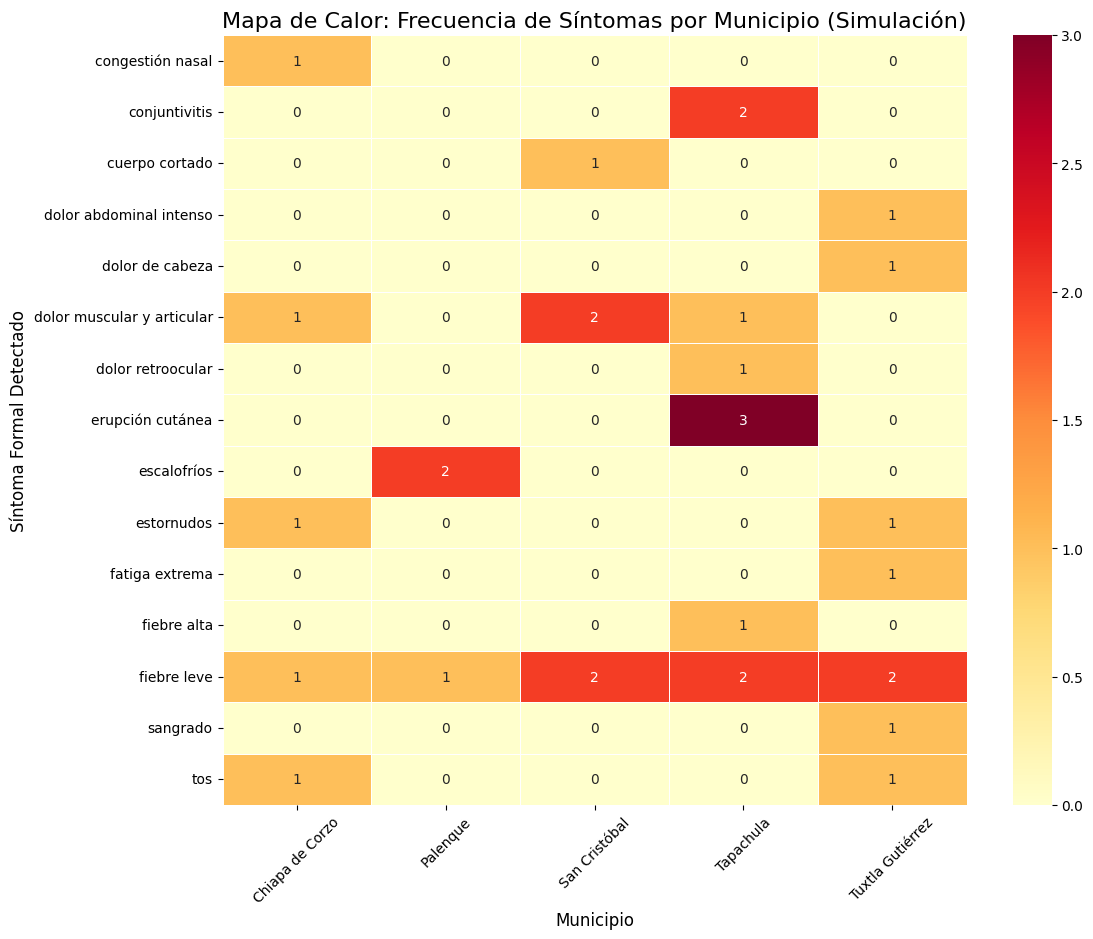

In [12]:
print("\n--- Generando Visualizacion del Mapa de Calor ---")

plt.figure(figsize=(12, 10)) 
sns.heatmap(
    tabla_calor, 
    annot=True,    
    fmt="d",        
    cmap="YlOrRd", 
    linewidths=.5   
)

plt.title("Mapa de Calor: Frecuencia de Síntomas por Municipio (Simulación)", fontsize=16)
plt.xlabel("Municipio", fontsize=12)
plt.ylabel("Síntoma Formal Detectado", fontsize=12)
plt.xticks(rotation=45) 

plt.show()

In [13]:
texto_de_prueba = "tengo calentura y me salieron ronchitas y me duele el cuerpo"

print(f"--- PRUEBA DE RANKING DE PROBABILIDAD ---")
print(f"Texto Original: '{texto_de_prueba}'")

sintomas_detectados = encontrar_sintomas_en_texto(texto_de_prueba, diccionario_db)
print(f"Síntomas Detectados: {sintomas_detectados}\n")

lista_completa_analisis = analizar_enfermedades(sintomas_detectados, data_db)

print("--- Ranking de Posibilidades (de mayor a menor) ---")

if not lista_completa_analisis:
    print("No se encontraron coincidencias.")
else:
    for resultado in lista_completa_analisis:
        print(f"Enfermedad: {resultado['enfermedad']}")
        print(f"  Confianza: {resultado['confianza']}%")
        print(f"  Nivel Urgencia: {resultado['nivel_urgencia']}")
        print(f"  Síntomas Coincidentes: {resultado['sintomas_coincidentes']}")
        print("-" * 20)

print("\n--- Diagnóstico Final---")
resultado_final = generar_respuesta_final(texto_de_prueba) 
print(json.dumps(resultado_final, indent=2, ensure_ascii=False))

--- PRUEBA DE RANKING DE PROBABILIDAD ---
Texto Original: 'tengo calentura y me salieron ronchitas y me duele el cuerpo'
Síntomas Detectados: ['erupción cutánea', 'fiebre leve', 'cuerpo cortado']

--- Ranking de Posibilidades (de mayor a menor) ---
Enfermedad: Zika
  Confianza: 66.67%
  Nivel Urgencia: Medio
  Síntomas Coincidentes: ['erupción cutánea', 'fiebre leve']
--------------------
Enfermedad: Malestares Generales
  Confianza: 33.33%
  Nivel Urgencia: Bajo
  Síntomas Coincidentes: ['cuerpo cortado']
--------------------
Enfermedad: Chikungunya
  Confianza: 33.33%
  Nivel Urgencia: Medio
  Síntomas Coincidentes: ['erupción cutánea']
--------------------
Enfermedad: Dengue Grave (Hemorrágico)
  Confianza: 33.33%
  Nivel Urgencia: Alto
  Síntomas Coincidentes: ['erupción cutánea']
--------------------

--- Diagnóstico Final---
{
  "diagnostico_probable": "Posible Zika",
  "confianza": 66.67,
  "nivel_urgencia": "Medio",
  "recomendacion_publica": "Tus síntomas (especialmente la eru